# Svenskt Kvinnobiografiskt lexikon part 3
version part 3 - 1.07


* this [Jupityr Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb) 
  * [part 1](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon.ipynb) check Wikidata and SKBL
  * [part 2](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%202.ipynb) more queries etc.
  

# Get metadata from SKBL and use it on the articles using Wikidata
Test getting the author data from SKBL  

If we get this data with license [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) "No rights reserved" we can store it in [Wikidata](https://www.wikidata.org/wiki/Wikidata:Licensing) and use it on all > 1500 articles in [sv:Wikipedia](https://sv.wikipedia.org/wiki/Kategori:SKBL) and [en:Wikipedia](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) using the [template SKBL](https://en.wikipedia.org/wiki/Template:SKBL) see also [Template Talk SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template) 

and display who the author is of the article in SKBL e.g. 
* Nauman, Sari [Ulrika Eleonora d.y., drottning](https://skbl.se/en/article/UlrikaEleonoradydrottning) at [Svenskt kvinnobiografiskt lexikon](https://en.wikipedia.org/wiki/Svenskt_kvinnobiografiskt_lexikon)

See also
* video [Introduction to WIkidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

# Wikidata

In [1]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?skblid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P4963 ?skblid
} order by ?skbl"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSKBLtot = get_sparql_dataframe(endpoint_url, querySKBL)
WDSKBLtot["Source"] = "SKBL" 
WDSKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 3 columns):
wid       1470 non-null object
skblid    1470 non-null object
Source    1470 non-null object
dtypes: object(3)
memory usage: 34.6+ KB


In [2]:
WDSKBLtot.sort_index(inplace=True)  

In [3]:
WDSKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 3 columns):
wid       1470 non-null object
skblid    1470 non-null object
Source    1470 non-null object
dtypes: object(3)
memory usage: 34.6+ KB


In [4]:
import csv  
import urllib3, json
http = urllib3.PoolManager() 

jsonURL = "https://skbl.se/sv/artikel/"
listNewItems =[]
for index,row in WDSKBLtot.iterrows():
    url = jsonURL + row["skblid"] + ".json"
    r = http.request('GET', url) 
    data = json.loads(r.data.decode('utf-8'))  
    new_item = dict()
    new_item['skblid'] = row["skblid"]
    new_item['wid'] = row["wid"]
    try:
        publishedDate = data['publication_date']        
    except:
        publishedDate =""
    new_item['publishedDate'] = publishedDate
    try:
        article_author_firstname = data['article_author'][0]['firstname']
    except:
        article_author_firstname =""
    new_item['article_author_firstname'] = article_author_firstname
    try:
        article_author_lastname = data['article_author'][0]['lastname']
    except:
        article_author_lastname =""
    new_item['article_author_lastname'] = article_author_lastname
    try:
        subtitle_sv = data['subtitle']
    except:
        subtitle_sv =""
    new_item['subtitle_sv'] = subtitle_sv
    try:
        subtitle_eng = data['subtitle_eng']
    except:
        subtitle_eng =""
    new_item['subtitle_eng'] = subtitle_eng
    try:
        name_lastname = data['name']['lastname']
    except:
        name_lastname = ""
    new_item['name_lastname'] = name_lastname
    try:
        name_firstname = data['name']['firstname']
    except:
        name_firstname = ""
    new_item['name_firstname'] = name_firstname
    listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")


1470  antal poster


In [5]:
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SKBLAuthor_newfile.csv", "w", newline='') as SKBLfile:
        dict_writer = csv.DictWriter(SKBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSKBLAuthorcsv = pd.read_csv("SKBLAuthor_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 
            


## Store Authorname in WIkidata 

1. Step nr one is that we just add the author as a text string e.g.
  1. Example article UlrikaEleonoradydrottning has in metadata json see line 1 below  

    1. article_author_firstname: "Sari"
    1. article_author_lastname: "Nauman" 
    
I guess then we create a authorname string **Nauman, Sari**

Many of the authors has an Wikipedia article on Swedish Wikipedia --> then we could add the author as a Wikilink e.g.
Lisbeth Larsson [Q4961115](https://www.wikidata.org/wiki/Q4961115) is same as SKBL [articleauthor/Larsson, Lisbeth](https://skbl.se/en/articleauthor/Larsson%2C%20Lisbeth)  

See also [en:Wikipedia:Template:Talk:SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template)

In [6]:
dfSKBLAuthorcsv["publishedDate"] = dfSKBLAuthorcsv["publishedDate"].astype("datetime64")
dfSKBLAuthorcsv["Source"] = "SKBL"

In [7]:
dfSKBLAuthorcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
skblid                      1470 non-null object
wid                         1470 non-null object
publishedDate               1470 non-null datetime64[ns]
article_author_firstname    1468 non-null object
article_author_lastname     1468 non-null object
subtitle_sv                 1470 non-null object
subtitle_eng                1467 non-null object
name_lastname               1438 non-null object
name_firstname              1470 non-null object
Source                      1470 non-null object
dtypes: datetime64[ns](1), object(9)
memory usage: 115.0+ KB


In [8]:
%matplotlib inline    
import matplotlib.pyplot as plt   


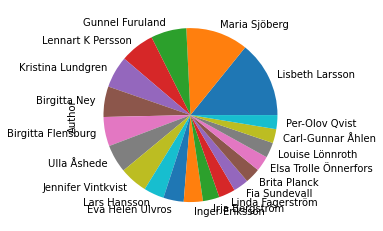

In [9]:
plotPublishedAuthor =   dfSKBLAuthorcsv  
  
plotPublishedAuthor["Author"] = plotPublishedAuthor["article_author_firstname"] + " " + plotPublishedAuthor["article_author_lastname"]   
plotAuthor = plotPublishedAuthor["Author"].value_counts()[:20]
plotAuthor.plot( kind = 'pie') 
plt.show()

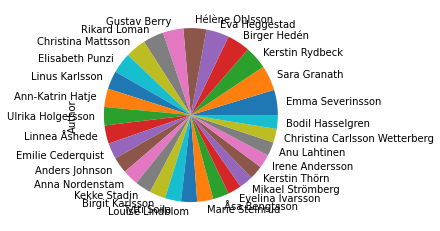

In [10]:
plotAuthor = plotPublishedAuthor["Author"].value_counts()[20:50]
plotAuthor.plot( kind = 'pie') 
plt.show()

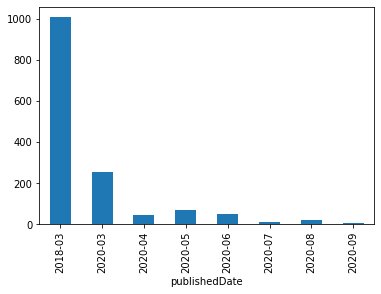

In [11]:
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(df['last_payout'].dt.to_period('M')).sum().plot(kind='bar')
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby([dfSKBLAuthorcsv.publishedDate.year,dfSKBLAuthorcsv.publishedDate.month].agg('count'))
plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(dfSKBLAuthorcsv.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.show()

In [12]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09       6
Freq: M, Name: publishedDate, dtype: int64

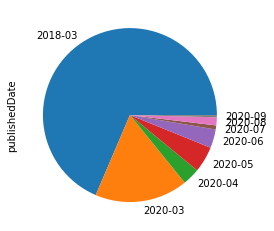

In [13]:
plotPublishedperMonth.plot( kind = 'pie')
plt.show()

In [14]:
pd.set_option('display.max_rows', None) 
# Sort latest first 
#dfSKBLAuthorcsv.sort_values(by=['publishedDate'], ascending=[False])

In [15]:
from IPython.display import display, HTML  
plotPublishedAuthor['Link'] = plotPublishedAuthor['skblid'].apply(lambda x: "https://skbl.se/sv/artikel/{0}".format(x))  
plotPublishedAuthor.sort_values(by=['publishedDate'], ascending=[False])[:50]

,skblid,wid,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,subtitle_eng,name_lastname,name_firstname,Source,Author,Link
1469,MariaLovisaFolkeson,Q98841779,2020-09-02,Gudrun,Nyberg,"Läkare, pionjär, nykterhetskämpe","Doctor, pioneer, temperance activist",Folkeson,/Maria/ Lovisa,SKBL,Gudrun Nyberg,https://skbl.se/sv/artikel/MariaLovisaFolkeson
1400,EvaFroberg,Q4949121,2020-09-02,Camilla,Bergvall,"Godsägare, politiker, kvinnosakskvinna","Property owner, politician, proponent of women...",Fröberg,/Eva/ Maria,SKBL,Camilla Bergvall,https://skbl.se/sv/artikel/EvaFroberg
1410,GallieAkerhielm,Q18275056,2020-09-02,Ulrika,Jannert Kallenberg,"Författare, journalist, översättare","Author, journalist, translator",Åkerhielm,/Gallie/,SKBL,Ulrika Jannert Kallenberg,https://skbl.se/sv/artikel/GallieAkerhielm
1404,EvaRamstedt,Q4974012,2020-09-02,Camilla,Bergvall,"Fysiker, docent, pionjär","Pioneering physicist, docent",Ramstedt,/Eva/ Julia Augusta,SKBL,Camilla Bergvall,https://skbl.se/sv/artikel/EvaRamstedt
1413,PetronellaNellyLaurentiaKrook,Q29886177,2020-09-02,Camilla,Bergvall,"Filantrop, donator, långivare","Philanthropist, donor, lender",Krook,Petronella (/Nelly/) Laurentia,SKBL,Camilla Bergvall,https://skbl.se/sv/artikel/PetronellaNellyLaur...
1468,BrithaSundstrom0,Q98841458,2020-09-02,Lena,Waldau,Entreprenör,Entrepreneur,Sundström,/Britha/,SKBL,Lena Waldau,https://skbl.se/sv/artikel/BrithaSundstrom0
1465,IngaBrittFredholm,Q98801372,2020-08-31,Eskil,Malmberg,"Sekreterare, författare","Secretary, author",Fredholm,/Inga-Britt/ Margareta,SKBL,Eskil Malmberg,https://skbl.se/sv/artikel/IngaBrittFredholm
1466,MargitBergendorff,Q98801384,2020-08-31,Chris,Bergendorff,"Lärare, entreprenör, formgivare","Teacher, entrepreneur, designer",Bergendorff,/Margit/ Agnes Sofia,SKBL,Chris Bergendorff,https://skbl.se/sv/artikel/MargitBergendorff
1467,MimmiCeciliaElisabethEkholm,Q98801409,2020-08-31,Kristin,Mörck,"Företagare, betongfabrikör",Concrete manufacturer,Ekholm,/Mimmi/ Cecilia Elisabeth,SKBL,Kristin Mörck,https://skbl.se/sv/artikel/MimmiCeciliaElisabe...
1415,AsaHolmsen,Q55178452,2020-08-31,Madeleine,Kleberg,"TV-producent, regissör","TV producer, director",Holmsen,/Åsa/ Margareta,SKBL,Madeleine Kleberg,https://skbl.se/sv/artikel/AsaHolmsen


## Compare SBL
SBL started in 1918 and is published by the National Archives in Sweden. They have
* No API
* focus on publish on paper
* dont have structured data
* no understanding of [Linked data](https://vimeo.com/36752317)
* we have before manually and doing webscrabing populated [Wikidata P3217](https://www.wikidata.org/wiki/Property_talk:P3217) now I guess we wait on SBL for delivering data as data see question asked [236883](https://phabricator.wikimedia.org/T236883)

In [16]:
# SPARQL 
querySBL = """SELECT distinct (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid  ?genderLabel ?birth ?death WHERE {
?item wdt:P31 wd:Q5.
OPTIONAL {?item wdt:P21 ?gender}
OPTIONAL {?item wdt:P569 ?birth}
OPTIONAL {?item wdt:P570 ?death}
?item wdt:P3217 ?sblid
SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
} order by ?sblid """


WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)
WDSBLtot["Source"] = "SBL" 
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 6 columns):
wid            8159 non-null object
sblid          8159 non-null object
genderLabel    8159 non-null object
birth          7919 non-null object
death          8053 non-null object
Source         8159 non-null object
dtypes: object(6)
memory usage: 382.6+ KB


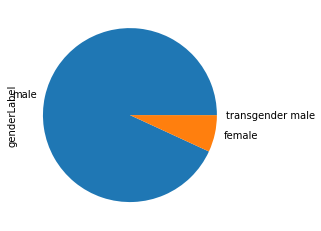

In [17]:
plotSBLgender = WDSBLtot["genderLabel"].value_counts()
plotSBLgender.plot( kind = 'pie') 
plt.show()

In [18]:
plotSBLgender

male                7598
female               560
transgender male       1
Name: genderLabel, dtype: int64

In [19]:
plotSBLfemale = WDSBLtot[WDSBLtot["genderLabel"] == "female"] 
#plotSBLfemale["birth"] = plotSBLfemale["birth"].astype("datetime64")
plotSBLfemale.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 7 to 8135
Data columns (total 6 columns):
wid            560 non-null object
sblid          560 non-null object
genderLabel    560 non-null object
birth          559 non-null object
death          557 non-null object
Source         560 non-null object
dtypes: object(6)
memory usage: 30.6+ KB
